<div align = 'center'>
    <h1 id="section-0"><font face = 黑体> 税务风险预警模型构建 </font>
<br>
<div>

<a id="ref11"></a>
### 实验步骤要求
<div class="alert alert-block alert-warning" style="margin-top: 20px">
1. 总体目标：确定风险等级划分，形成税务风险预警模型<br>
2. 具体要求：编写函数实现企业风险指标总分的计算与企业风险等级的划分
</div>

<a id = "ref12"></a>
### 数据说明
<div class="alert alert-block alert-success" style="margin-top: 20px">
在实验 6 中，我们通过计算得到了“三表中企业各项税务风险指标的计算结果”（output/indicators.csv）和“各项指标的行业预警值”（output/result_warning.csv）；在实验 7 中，通过层次分析法我们得到了各项指标的权重信息，该数据已被存储到 output 文件夹下的 weights.csv 文件中，文件横轴代表各项指标名称，纵轴表示“二级指标权重”和“三级指标权重”。关于上述三份文件的具体内容，您可以添加代码块输出相应变量查看。
</div>

In [1]:
import pandas as pd

## weights (pandas.DataFrame): 行业税务风险指标权重
weights = pd.read_csv("output/weights.csv", index_col = 0)

## warning_interval (pandas.DataFrame): 行业税务风险指标预警值
warning_interval = pd.read_csv("output/result_warning.csv", index_col = 0)

## indicators (pandas.DataFrame): 企业税务风险指标数据
indicators = pd.read_csv("output/indicators.csv")
indicators['证券代码'] = indicators['证券代码'].apply(lambda x: f'{x:06d}')

## 这里为测试方便，只选择了部分指标，实际中下面一行代码需注释掉
indicators = indicators[[
    '证券代码',
    '证券简称',
    '营业收入变动率',
    '营业成本变动率',
    '营业费用变动率',
    '销售费用变动率',
    '管理费用变动率',
    '财务费用变动率',
    '研发费用变动率',
    '成本费用利润率',
    '营业利润变动率',
    '营业外收入变动率',
    '营业收入变动率与营业利润变动率配比',
    '营业收入变动率与营业成本变动率配比',
    '营业收入变动率与营业费用变动率配比',
    '营业成本变动率与营业利润变动率配比',
    '增值税税收负担率',
    '应纳税额与工业增加值弹性系数',
    '工业增加值税负差异率'
]]

<a id = "ref13"></a>
### 企业风险指标得分计算说明
<div class="alert alert-block alert-info" style="margin-top: 20px">
企业风险指标得分的计算分为以下四个步骤：
<li>1. 计算出各企业非配比指标的得分，以某企业指标“营业收入变动率”为例：</li>
<ul class = "toc-item">
        1.1. 企业计算指标值位于预警值范围内（含边界）：

$$  S_{x,i}=100,\quad\quad L_x \le x_i \le U_x  $$
其中 $S_{x,i}$ 表示第 $i$ 个企业“营业收入变动率”指标的得分，$x_i$ 表示第 $i$ 个企业的“营业收入变动率”，$U_x$ 和 $L_x$ 分别表示“营业收入变动率”指标行业预警值的上下界。  
        1.2. 企业计算指标值位于预警值范围外：  
首先计算各企业非配比指标的风险偏离度：
$$ D_{x,i}= \lvert \frac{x_i-\overline{x}}{\overline{x}} \rvert $$
其中 $D_{x,i}$ 表示第 $i$ 个企业“营业收入变动率”指标的风险偏离度，$x_i$ 表示第 $i$ 个企业的“营业收入变动率”，$\overline{x}$ 表示“营业收入变动率”指标的行业均值。  
风险偏离度每达到 $20\%$ 得分减 $1$，最低 $0$ 分：
$$  S_{x,i}=max(100-\lfloor \frac{ D_{x,i} }{0.2} \rfloor, 0),\quad\quad x_i < L_x \enspace or \enspace x_i > U_x  $$
</ul>

<li>2. 计算出各企业配比指标的得分，以某企业指标“营业收入变动率与营业成本变动率配比”为例：</li>  
<ul class = "toc-item">
        2.1. 企业计算指标值位于预警值范围内（含边界）：

$$  S_{y,i}=100,\quad\quad 0.7 \le y_i \le 1.3  $$
其中 $S_{y,i}$ 表示第 $i$ 个企业“营业收入变动率与营业成本变动率配比”指标的得分，$y_i$ 表示第 $i$ 个企业的“营业收入变动率与营业成本变动率配比”。  
        2.2. 企业计算指标值小于预警下限：

$$ S_{x,i}=max(100-\lfloor \frac{ 0.7-y_i }{0.2} \rfloor, 0),\quad\quad y_i < 0.7 $$  
2.3. 企业计算指标值大于预警上限：

$$ S_{x,i}=max(100-\lfloor \frac{ y_i-1.3 }{0.2} \rfloor, 0),\quad\quad y_i > 1.3 $$
</ul>

<li>3. 对各指标得分加权求和得到企业风险指标总分：</li>

$$ S_i=\sum_{k=1}^{3}w_{2k}\sum_{j\in m_k}w_{3j}S_{ij} $$
$\quad$ 其中 $S_i$ 表示第 $i$ 个企业的风险指标总分，$w_{2k}$ 表示第 $k$ 个二级指标权重，$w_{3j}$ 表示所选取第 $j$ 个三级指标权重，$m_k$ 表示属于第 $k$ 个二级指标下面的三级指标集合，$S_{ij}$表示第 $i$ 个企业第 $j$ 个指标的得分。  
</div>
</div>

<a id = "ref14"></a>
### 企业风险等级判断说明
<div class="alert alert-block alert-info" style="margin-top: 20px">
企业风险等级需根据企业风险指标总分进行判断，分为“低风险”、“中风险”和“高风险”三类，具体判断方式如下表：  

<center>-</center>
<table style="margin-left: auto; margin-right: auto;">
  <tr>
    <th style="text-align:center;">风险指标总分</th>
    <th style="text-align:center;">风险等级</th>
  </tr>
  <tr>
    <td style="text-align:center;">[80-100]</td>
    <td style="text-align:center;">低风险</td>
  </tr>
  <tr>
    <td style="text-align:center;">[50-80)</td>
    <td style="text-align:center;">中风险</td>
  </tr>
  <tr>
    <td style="text-align:center;">[0-50)</td>
    <td style="text-align:center;">高风险</td>
  </tr>
</table>

<div class="alert alert-block alert-info" style="margin-top: 20px">
&emsp;&emsp;关于具体代码的编写，下方预定义了一个名为 risk_level_calculation 的函数，该函数用来计算企业风险指标总分并据此判断企业风险等级。函数需传入四个参数：“企业税务风险指标数据”、“行业税务风险指标预警值”、“行业税务风险指标权重” 以及 “指标类型信息（配比或非配比）”，但后三个参数在实际运用模型前已被计算出。函数返回“企业各风险指标得分”、“企业风险指标总分”以及“企业风险等级”。关于输入和输出内容的格式已在函数中定义。请完成该函数，下面是一些注意事项：
<li>1. 您需要在函数中完成对所选择指标是配比指标还是非配比指标的判断，关于您所选指标的分类已存储在 ratio_ratio_group_infos 中，您可运行下方代码查看该变量</li>
<li>2. indicators（企业税务风险指标数据）的数据类型是 DataFrame，其中每一行数据表示一个企业的各项指标值，在之前计算行业税务风险指标预警值时我们没有对其中的缺失值进行处理，这是因为在按指标列计算均值和标准差时自动将 np.nan 排除在外了，但在这里对于一个企业，所选的每一个指标都不应存在计算值的缺失，所以我们会将 indicators 中含有缺失值的行删去。您不需要考虑传入的 indicators 中存在缺失值的问题。</li>
</div>

In [2]:
import json

## 载入对所选指标的分组信息（配比或非配比）
with open('data/配比指标划分.json', 'r') as file:
    ratio_ratio_group_infos = json.load(file)

'''
ratio_ratio_group_infos = {
    'non_ratio_ratio_indicator': ['indicator1', 'indicator2', 'indicator3', ...],  ## 非配比指标
    'ratio_ratio_indicator': ['indicator4', 'indicator5', 'indicator6', ...]  ## 配比指标
}
'''
# print(ratio_ratio_group_infos)

def risk_level_calculation(indicators, warning_interval, weights, ratio_ratio_group_infos):
    """
    计算企业风险指标总分并判断企业风险等级。
    
    Args:
        indicators (pandas.dataframe): 包含企业各风险指标计算值的数据框（企业税务风险指标数据）, 列索引为 ['证券代码', '证券简称','XXX指标1', 'XXX指标2', ...];
        warning_interval (pandas.dataframe): 包含各风险指标预警值的数据框（行业税务风险指标预警值）, 该数据是提前算出来后存下来的;
        weights (pandas.dataframe): 包含各风险指标权重的数据框（行业税务风险指标权重）, 该数据是提前算出来后存下来的;
        ratio_ratio_group_infos (dict): 所选指标的分组信息（配比或非配比）, 该信息在选取指标时就已被确认。
    
    return:
        包含各企业各项指标的单位风险值、各企业加权汇总风险值等结果的元组 (tuple): (scores_unweighted, score_sum, risk_level)
        其中:
            scores_unweighted (pandas.dataframe): 企业各风险指标得分, 列索引为 ['证券代码', '证券简称','XXX指标1', 'XXX指标2', ...]
            score_sum (pandas.dataframe): 企业风险指标总分, 列索引为 ['证券代码', '证券简称','风险总分']
            risk_level (pandas.dataframe): 企业风险等级, 列索引为 ['证券代码', '证券简称','风险等级']
    """

    ## 从 indicators 中提取出企业名称和风险指标数据
    name_index = indicators.iloc[:,:2]
    indicators = indicators.iloc[:,2:]

    def calculation_helper_1(indicator):
        lower_bound, upper_bound = warning_interval.loc['预警值下限'][indicator.name], warning_interval.loc['预警值上限'][indicator.name]

        if indicator.name in ratio_ratio_group_infos['non_ratio_ratio_indicator']:
            print('非配比指标: ', indicator.name, ' ', lower_bound, ' ', upper_bound)

            mean = warning_interval.loc['行业均值'][indicator.name]

            def score_calculation_1(value, lower_bound, upper_bound, mean):
                if lower_bound <= value <= upper_bound:
                    return 100
                else:
                    risk_deviation_degree = abs((value - mean) / mean)
                    return max(100 - risk_deviation_degree // 0.2, 0)
                
            return indicator.apply(
                lambda x: score_calculation_1(x, lower_bound, upper_bound, mean)
            )
        
        elif indicator.name in ratio_ratio_group_infos['ratio_ratio_indicator']:
            print('配比指标: ', indicator.name, ' ', lower_bound, ' ', upper_bound)

            def score_calculation_2(value, lower_bound, upper_bound):
                if lower_bound <= value <= upper_bound:
                    return 100
                elif value > upper_bound:
                    return max(100 - (value - upper_bound) // 0.2, 0)
                else:
                    return max(100 - (lower_bound - value) // 0.2, 0)

            return indicator.apply(
                lambda x: score_calculation_2(x, lower_bound, upper_bound)
            )
        
        else:
            raise ValueError(indicator.name, ' 指标分组错误！')

    scores_unweighted = indicators.apply(calculation_helper_1)

    def calculation_helper_2(indicator):
        return indicator * weights.loc['二级指标权重'][indicator.name]
    
    def calculation_helper_3(indicator):
        return indicator * weights.loc['三级指标权重'][indicator.name]
    
    scores_weighted_1 = scores_unweighted.apply(calculation_helper_2).round(4)

    scores_weighted_2 = scores_weighted_1.apply(calculation_helper_3).round(4)

    score_sum = pd.Series(scores_weighted_2.sum(axis = 1), name = '风险总分').round(4)

    def calculation_helper_4(score_sum):
        def score_categorize(score):
            if 0 <= score < 50:
                return '高风险'
            elif 50 <= score < 80:
                return '中风险'
            elif 80 <= score <= 100:
                return '低风险'
            else:
                raise ValueError(f'风险总分 {score} 超过既定范围！')

        return score_sum.apply(score_categorize)
    
    risk_level = calculation_helper_4(score_sum).rename('风险等级')

    scores_unweighted = pd.concat([name_index, scores_unweighted], axis = 1)
    scores_weighted_1 = pd.concat([name_index, scores_weighted_1], axis = 1)
    scores_weighted_2 = pd.concat([name_index, scores_weighted_2], axis = 1)
    score_sum = pd.concat([name_index, score_sum], axis = 1)
    risk_level = pd.concat([name_index, risk_level], axis = 1)

    return (scores_unweighted, score_sum, risk_level)

## 计算企业风险指标总分并判断企业风险等级，这个传入的 indicators 已去除存在指标缺失的企业数据
scores_unweighted, score_sum, risk_level = risk_level_calculation(indicators.dropna().reset_index(drop = True), warning_interval, weights, ratio_ratio_group_infos)

非配比指标:  营业收入变动率   -26.66102360940085   22.906917953924733
非配比指标:  营业成本变动率   -20.837415379193004   18.88237290077088
非配比指标:  营业费用变动率   -11.4630355035277   21.20704194945469
非配比指标:  销售费用变动率   -13.552241769036474   19.85824858823209
非配比指标:  管理费用变动率   -10.693134048016107   12.6550633924579
非配比指标:  财务费用变动率   -83.38565493946244   51.31382360217636
非配比指标:  研发费用变动率   -53.87723723644554   23.06324150145436
非配比指标:  成本费用利润率   -4.249123646883749   4.684789187274348
非配比指标:  营业利润变动率   -149.41403082536678   50.14367252194993
非配比指标:  营业外收入变动率   -95.37221556678826   5.9843208623186825
配比指标:  营业收入变动率与营业利润变动率配比   0.7   1.3
配比指标:  营业收入变动率与营业成本变动率配比   0.7   1.3
配比指标:  营业收入变动率与营业费用变动率配比   0.7   1.3
配比指标:  营业成本变动率与营业利润变动率配比   0.7   1.3
非配比指标:  增值税税收负担率   1.936172515265501   5.569831913260073
非配比指标:  应纳税额与工业增加值弹性系数   -0.0588944160872073   0.1006634996927278
非配比指标:  工业增加值税负差异率   -0.3608952494560207   2.3608952494560205


<a id = "ref15"></a>
### 数据可视化

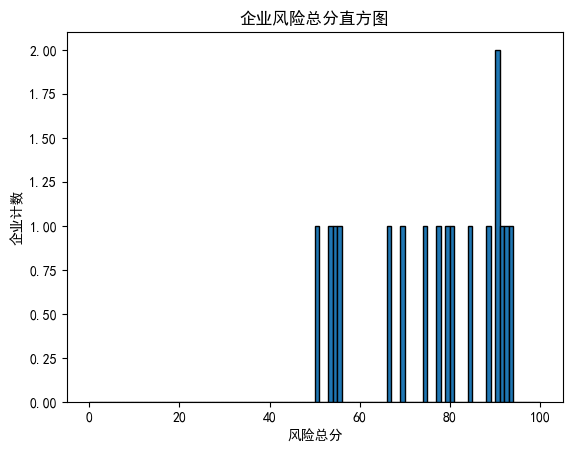

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']

plt.hist(score_sum['风险总分'], bins=range(0, 101, 1), edgecolor='black')
plt.title('企业风险总分直方图')
plt.xlabel('风险总分')
plt.ylabel('企业计数')
plt.show()

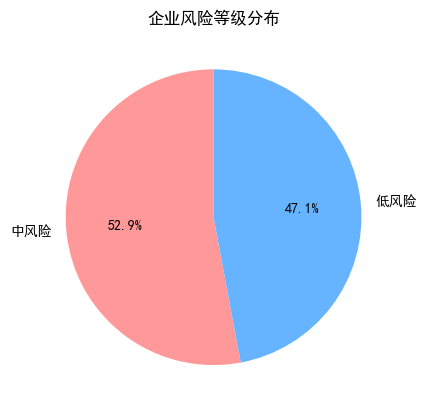

In [4]:
risk_counts = risk_level['风险等级'].value_counts()
plt.pie(risk_counts, labels = risk_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('企业风险等级分布')
plt.show()